In [7]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Load dataset
data = pd.read_csv('TESLA.csv')
print(data.head())

# Convert the 'Date' column to timestamp
data['Date'] = pd.to_datetime(data['Date'])
data['Date'] = data['Date'].apply(lambda x: x.timestamp())

# Prepare the data
data_values = data.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_values)

# Parameters
time_steps = 10
target_column_index = data.columns.get_loc('Close')

# Create input features and target variable
X, y = [], []
for i in range(len(scaled_data) - time_steps):
    X.append(scaled_data[i:i + time_steps])
    y.append(scaled_data[i + time_steps, target_column_index])

X, y = np.array(X), np.array(y)

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Reshape X for MLP (flatten the time-step dimension)
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Define MLP model function with L2 regularization
def build_model(learning_rate):
    model = Sequential()
    model.add(Dense(units=128, activation='relu', input_dim=X_train.shape[1], kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Dropout(0.3))  # Dropout for regularization
    model.add(Dense(units=64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Dense(units=1))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Wrap model in KerasRegressor for GridSearchCV
model = KerasRegressor(model=build_model, verbose=0)

# Hyperparameter grid search
param_grid = {
    'model__learning_rate': [0.0001, 0.001, 0.01],
    'batch_size': [16, 32],
    'epochs': [50, 100]
}

# Perform GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train, validation_data=(X_val, y_val))

# Print the best parameters found
print(f'Best parameters found: {grid_result.best_params_}')
best_model = grid_result.best_estimator_.model_

# Early stopping callback to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = best_model.fit(X_train, y_train, epochs=grid_result.best_params_['epochs'], 
                         batch_size=grid_result.best_params_['batch_size'], 
                         validation_data=(X_val, y_val),
                         callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss = best_model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Make predictions
y_pred = best_model.predict(X_test)

# Inverse transform predictions and actual values to original scale
def inverse_transform(y_scaled, original_data_shape):
    extended_data = np.zeros((y_scaled.shape[0], original_data_shape[1]))
    extended_data[:, target_column_index] = np.squeeze(y_scaled)
    return scaler.inverse_transform(extended_data)[:, target_column_index]

y_test_rescaled = inverse_transform(y_test, scaled_data.shape)
y_pred_rescaled = inverse_transform(y_pred, scaled_data.shape)


         Date   Open   High    Low  Close  Adj Close    Volume
0  2010-06-29  3.800  5.000  3.508  4.778      4.778  93831500
1  2010-06-30  5.158  6.084  4.660  4.766      4.766  85935500
2  2010-07-01  5.000  5.184  4.054  4.392      4.392  41094000
3  2010-07-02  4.600  4.620  3.742  3.840      3.840  25699000
4  2010-07-06  4.000  4.000  3.166  3.222      3.222  34334500
Best parameters found: {'batch_size': 16, 'epochs': 100, 'model__learning_rate': 0.0001}
Epoch 1/100
111/111 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 2/100
111/111 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 3/100
111/111 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 9.9702e-04
Epoch 4/100
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 5/100
111/111 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 9.4093e-04
Epoch 6/100
111/111 

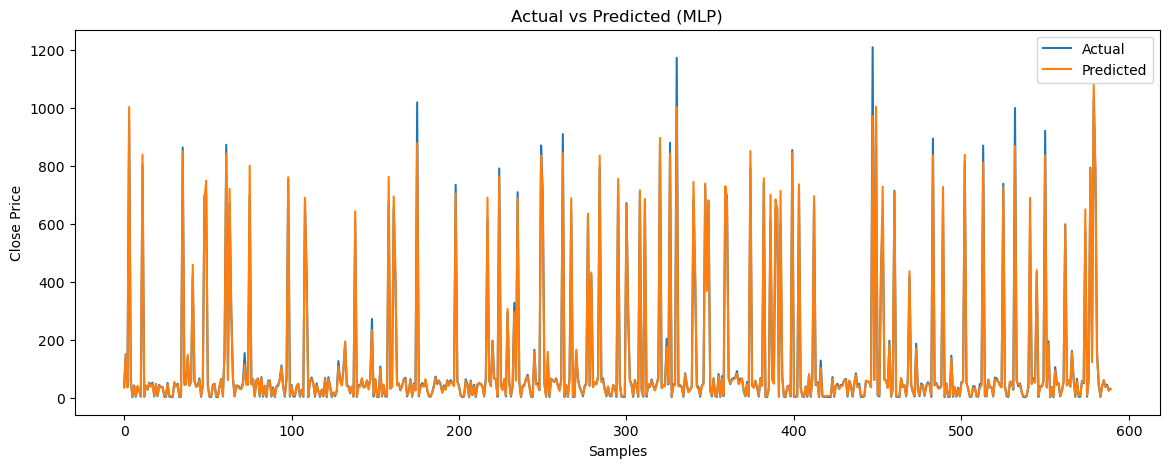

In [9]:
# Plot actual vs predicted values
plt.figure(figsize=(14, 5))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(y_pred_rescaled, label='Predicted')
plt.title('Actual vs Predicted (MLP)')
plt.xlabel('Samples')
plt.ylabel('Close Price')
plt.legend()
plt.show()

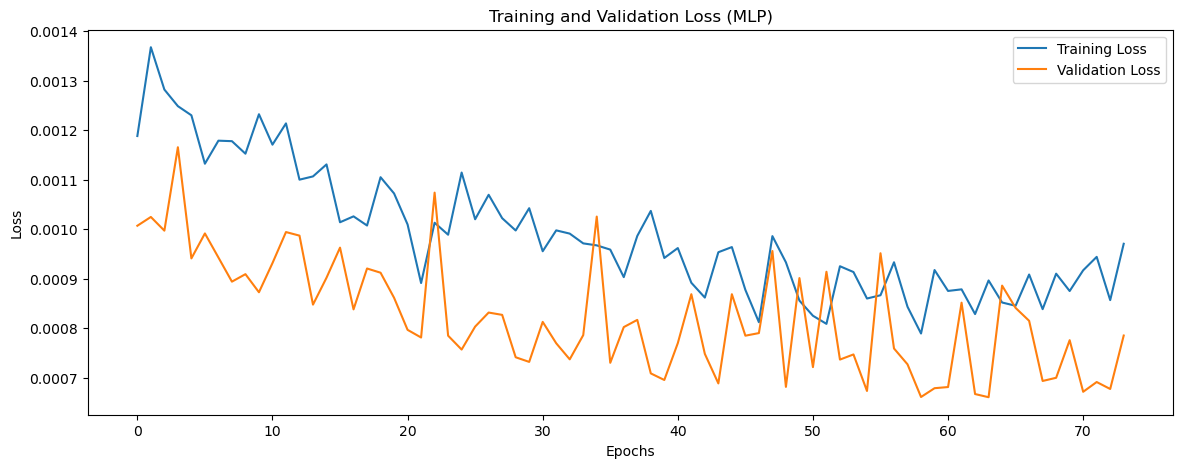

In [11]:
# Plot training and validation loss
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (MLP)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()